# Titanic - Machine Learning from Disaster 

- Daniel Betzalel
- https://www.kaggle.com/danielbetzalel
- Shai Odeni
- https://www.kaggle.com/shaiodeni

## TL;DR
The assignment was to predict the survivors on the Titanic ship according to the given features. We separated the work into 6 parts:

1. **Imports and Definitions** - Importing necessary libraries and setting up global settings.
2. **Data Investigation EDA** - Exploring and understanding the dataset using statistical analysis and visualization.
3. **Data Cleaning and Preprocessing** - Handling missing values, outliers, and encoding categorical variables.
4. **Feature Selection** - Choosing the most relevant features for the model.
5. **Model Selection and Training** - Choosing, training, and tuning a machine learning model.
6. **Tests Model** - Evaluating the model's performance on a test set.




## Part 1 Imports and Definitions


In [ ]:
# import numpy, matplotlib, etc.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import uniform

# sklearn imports
import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import neural_network
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import LeavePOut
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import os


# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20


In [ ]:
SHOW_GRAPHS = False

- define the input and output folders


In [ ]:
input_folder = "input/"

train_data_path = os.path.join(input_folder, "train.csv")
test_data_path = os.path.join(input_folder, "test.csv")

#### Load the traning data


- Load the csv data to variables

In [ ]:
train_data = pd.read_csv(train_data_path)

test_data = pd.read_csv(test_data_path)


## Part 2 Data Investigation EDA


The columns that we will drop are:
- PassengerId: it is just an index
- Name: it is not relevant for the model
- Ticket: it is not relevant for the model

In [ ]:
from sklearn.preprocessing import LabelEncoder

DROP_DATA = ["PassengerId", "Name", "Ticket"]
def remove_Unused_Columns(data):
    data = data.drop(DROP_DATA, axis=1)
    return data


le = LabelEncoder()
def convet_gender_to_numric(df):
    """   
    "sex" column ===> male = 1, female = 0
    """
    df['Sex'] = le.fit_transform(df['Sex'])

In [ ]:
train_data = remove_Unused_Columns(train_data)

# passenger_ids save the passenger ids for the test data for the submission
passenger_ids = test_data['PassengerId']
test_data = remove_Unused_Columns(test_data)


In [ ]:
train_data.head()

- Convert Men/Women to 1/0

In [ ]:
convet_gender_to_numric(train_data)

convet_gender_to_numric(test_data)

In [ ]:
train_data.head()

Get summary statistics for the training dataset show only the numerical columns


In [ ]:
train_data.describe()


Get the number of missing values in the training dataset


In [ ]:
display(train_data.isnull().sum())

The dataset contains missing values in the following columns:

1) Age: 177 missing values
2) Cabin: 687 missing values (cabin has a lot of missing values)
3) Embarked: 2 missing values




- Get the data types of the columns in the training dataset


In [ ]:
display(train_data.info())

- We can see that most of the data is int64 or float64, only the Cabin and Embarked Are object types (String)

### Display the features


In [ ]:
def plot_and_calculate(df, column):
    # Plot the survival rate
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue='Survived', data=df)
    plt.title(f'Survival Rate by {column}')
    plt.show()

    # Group by column and 'Survived', then get the size of each group
    grouped = df.groupby([column, 'Survived']).size()

    # Calculate the percentage of survivors
    percentage_survived = grouped.xs(1, level='Survived') / grouped.groupby(level=column).sum() * 100

    # Print the percentage of survivors
    print(f"Percentage of survivors for each {column}:")
    print(percentage_survived)

- In this section, we will explore the relationship between the survival rate and some of the features in the dataset.
- After each graph, we will print the percentage of survivors for each category in the feature.

In [ ]:
if SHOW_GRAPHS:
    plot_and_calculate(train_data, 'Embarked')
    plot_and_calculate(train_data, 'Parch')
    plot_and_calculate(train_data, 'SibSp')
    plot_and_calculate(train_data, 'Sex')
    plot_and_calculate(train_data, 'Pclass')


Now we can study from this graph
1) From port C more people survived but from S and Q most of the people died
2) Most women survived (74%)
3) Most people from Pclass 1 survived (63%) but most people from Pclass 3 died (76% died)

**Pairplot Visualizing Correlation**

- Now we will display the pairplot of the data we can see the correlation between the features

In [ ]:
if SHOW_GRAPHS:
    sns.pairplot(train_data[['Survived', 'Pclass', 'Age', 'Fare', 'Sex']], hue='Survived')
    plt.show()

**Heatmap for correlation matrix**


In [ ]:
if SHOW_GRAPHS:
    plt.figure(figsize=(10, 6))
    corr_matrix = train_data.corr(numeric_only=True)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

- We can see that the correlation between the Survived and features like Pclass, Fare are high.


## Part 3 Data Cleaning and Preprocessing

Check for missing values in the train dataset


In [ ]:
print(train_data.isnull().sum())

Fill Missing Values
- Categorical columns with the most frequent value 
- Numerical columns with the mean
- Drop the Cabin column due to too many missing value

In [ ]:
from sklearn.impute import SimpleImputer

# fill missing values, the 


def fill_missing_values(data):
    data['Age'] = data['Age'].fillna(data['Age'].mean())
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    data = handle_missing_values(data)
    return data


def drop_missing_values(data):
    data.drop(columns=['Cabin'], inplace=True)
    return data


def handle_missing_values(data):    
    # Impute numerical columns with mean
    imputer_num = SimpleImputer(strategy='mean')
    data[data.select_dtypes(include=['number']).columns] = imputer_num.fit_transform(data.select_dtypes(include=['number']))
    
    # Impute categorical columns with constant value 'missing'
    imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
    data[data.select_dtypes(exclude=['number']).columns] = imputer_cat.fit_transform(data.select_dtypes(exclude=['number']))
    
    return data



In [ ]:
#there's only two people with NaN, after searching about them it was find out they board in Southampton 
train_data["Embarked"] = train_data.loc[:, 'Embarked'].fillna('S')

train_data = drop_missing_values(train_data)
train_data = fill_missing_values(train_data)

# test data
test_data = drop_missing_values(test_data)
test_data = fill_missing_values(test_data)


In [ ]:
print(train_data.isnull().sum())

print(test_data.isnull().sum())

### Convert Categorical Variables into Numerical Values
- Embarked use One-hot encode

In [ ]:
def encode_categorical(data):
    # One-hot encode the categorical columns
    data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)
    return data

In [ ]:
# train_data = encode_categorical(train_data)

# test_data = encode_categorical(test_data)


In [ ]:
train_data.head()

In [ ]:
print(train_data.isnull().sum())

Standardize Numerical Features
- Standardize Age and Fare to have a mean of 0 and a standard deviation of 1.

In [ ]:
from sklearn.preprocessing import StandardScaler

def scale_data(data):
    # Initialize the scaler
    scaler = StandardScaler()
    data[['Age', 'Fare']] = scaler.fit_transform(data[['Age', 'Fare']])
    
    return data

In [ ]:
# train_data = scale_data(train_data)

# test_data = scale_data(test_data)


In [ ]:
train_data.head()

### Create New Features
 - Family Size from SibSp and Parch
 - Is Alone from the FamilySize
 - Remove SibSp and Parch columns becuse of the new features

In [ ]:
def create_features(data):
    """
    Create new features for the dataset.
    """
    # Create FamilySize feature 
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

    # Create IsAlone feature
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
    
    return data

def drop_features(data):
    data.drop(columns=['SibSp', 'Parch'], inplace=True)
    return data
    

In [ ]:
# train data
train_data = create_features(train_data)
train_data = drop_features(train_data)
# test data
test_data = create_features(test_data)
test_data = drop_features(test_data)


In [ ]:
train_data.head()

Final Dataset

In [ ]:
print(train_data.head())

print("\n\nmissing values in train data:\n")
print(train_data.isnull().sum())


In [ ]:
train_data.info()

In [ ]:
if SHOW_GRAPHS:
    corr_matrix = train_data.corr(numeric_only=True)
    sorted_columns = corr_matrix.abs().sort_values('Survived', ascending=False).index
    sorted_corr_matrix = corr_matrix.reindex(index=sorted_columns, columns=sorted_columns)

    fig = go.Figure(data=go.Heatmap(
        z=sorted_corr_matrix.values,
        x=sorted_corr_matrix.columns,
        y=sorted_corr_matrix.columns,
        colorscale='Viridis',
        text=sorted_corr_matrix.values.round(2),
        texttemplate="%{text}",
        showscale=True
    ))
    fig.update_layout(title='Correlation Matrix Sorted by "Survived"', width=1000, height=800)
    fig.show()

# Exercise 3

## TL;DR
The assignment was to predict the survivors on the Titanic ship according to the given features. We separated the work into 7 parts:

1. **Feature Selection with RFECV** - Utilizing Recursive Feature Elimination with Cross-Validation to identify the most significant features.
2. **Hyperparameter Tuning** - Employing Grid and Random Search methods to find the optimal model parameters.
3. **Ensemble Methods** - Implementing Bagging and Boosting techniques, including AdaBoost, to improve model performance.
4. **Model Comparison** - Evaluating different models such as KNN, Naive Bayes, and LDA to select the best performer.
5. **Cross-validation for Performance Evaluation** - Using cross-validation techniques like K-Fold & LPOUT
6. **Best Model Predictions on Test Set** - Applying the best-performing model to make predictions on the test dataset.
7. **Kaggle Submission File Creation** - Preparing and submitting the prediction results to Kaggle.

Throughout this process, we relied on various metrics and visualizations to guide our decision-making.

- Split the data into features and target


In [ ]:
X = train_data.drop(columns='Survived')
t = train_data['Survived']

In [ ]:
print("X shape: ", X.shape)

- Normalize the data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# use column transformer to insert different transformers for each column
from sklearn.compose import ColumnTransformer

numerical_cols = X.select_dtypes(include=['int32', 'int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
all_cols = list(categorical_cols) + list(numerical_cols)
ct_enc_std = ColumnTransformer([
            ("encoding", OrdinalEncoder(), categorical_cols),
            ("standard", StandardScaler(), numerical_cols)])
X_enc = pd.DataFrame(ct_enc_std.fit_transform(X, t), columns=all_cols)
test_X_enc = pd.DataFrame(ct_enc_std.fit_transform(test_data), columns=X_enc.columns.values.tolist())
X = X_enc
test_data = test_X_enc
print("X shape: ", X.shape)

#### KPI functions

- Calculate key performance indicators (KPIs)

In [ ]:
def kpis(cm):
    """
    Calculate key performance indicators (KPIs) from a confusion matrix.
    
    Parameters:
    cm (numpy.ndarray): Confusion matrix
    
    Returns:
    dict: Dictionary containing precision, recall, specificity, false positive rate, and accuracy.
    """
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    fpr = fp / (fp + tn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return {
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'Specificity': round(specificity, 2),
        'FPR': round(fpr, 2),
        'Accuracy': round(accuracy, 2),
        'F1 Score': round(f1, 2)
    }

- Show the KPI table

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_kpi_table(kpi_values):
    """
    Display KPIs in a table using Seaborn and Matplotlib.
    
    Parameters:
    kpi_values (dict): Dictionary containing KPI names as keys and KPI values as values.
    """
    df = pd.DataFrame(list(kpi_values.items()), columns=["KPI", "Value"])

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.title("Key Performance Indicators (KPIs)", fontsize=14)
    plt.show()
    


- Display the confusion matrix as a heatmap and print key performance indicators

In [ ]:
def confusion_matrix_KPIs(cm):
    """
    Display the confusion matrix as a heatmap using Plotly and print key performance indicators.
    Parameters:
    cm (numpy.ndarray): Confusion matrix
    """
    # Convert confusion matrix to DataFrame for easy plotting
    cm_train_df = pd.DataFrame(cm, index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm_train_df, annot=True, cmap=plt.cm.Pastel1, fmt='g')
    plt.title('Train Confusion Matrix')
    plt.show()

    # Calculating KPIs using the provided kpis function
    kpi_values = kpis(cm)
    plot_kpi_table(kpi_values)

### Cross Validation

- calculate score and loss from cv (KFold or LPO) and display graphs


In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedKFold, LeavePOut
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn import metrics

def get_cv_score_and_loss(X, t, model, k=None, p=None, show_score_loss_graphs=True, show_cm=True):
    # Initialize a DataFrame to store scores and losses
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])

    # Determine the type of cross-validation to use
    if k is not None:
        cv = RepeatedKFold(n_splits=k, n_repeats=10, random_state=1)  # K-Fold cross-validation
    elif p is not None:
        cv = LeavePOut(p)  # Leave-P-Out cross-validation
    else:
        raise ValueError('You need to specify either k or p for cross-validation.')

    # List to store confusion matrices for each fold
    conf_matrix_list_of_arrays = []
    
    # Iterate over each fold in the cross-validation
    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        # Split the data into training and validation sets
        X_train = X.loc[X.index.intersection(train_ids)]
        t_train = t.loc[t.index.intersection(train_ids)]
        X_val = X.loc[X.index.intersection(val_ids)]
        t_val = t.loc[t.index.intersection(val_ids)]

        # Fit the model on the training set
        model.fit(X_train, t_train)

        # Predict on the training and validation sets
        y_train = abs(model.predict(X_train))
        y_val = abs(model.predict(X_val))
        
        # Store scores and losses
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'train', model.score(X_train, t_train), metrics.log_loss(y_train, t_train)]
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'val', model.score(X_val, t_val), metrics.log_loss(y_val, t_val)]

        # Compute the confusion matrix for the validation set and store it
        conf_matrix = confusion_matrix(t_val, y_val)
        conf_matrix_list_of_arrays.append(conf_matrix)

    # Separate the scores and losses for training and validation sets
    val_scores_losses_df = scores_losses_df[scores_losses_df['split'] == 'val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split'] == 'train']

    # Calculate mean scores and losses
    mean_val_score = val_scores_losses_df['score'].mean()
    mean_val_loss = val_scores_losses_df['loss'].mean()
    mean_train_score = train_scores_losses_df['score'].mean()
    mean_train_loss = train_scores_losses_df['loss'].mean()

    # Calculate the mean confusion matrix across all folds
    mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

    # Plot the score and loss graphs if requested
    if show_score_loss_graphs:
        # Plotting Score Graph
        plt.figure(figsize=(14, 6))
        for split in scores_losses_df['split'].unique():
            subset = scores_losses_df[scores_losses_df['split'] == split]
            plt.plot(subset['fold_id'], subset['score'], label=f'{split} Score')
        plt.title(f'Mean Val Score: {mean_val_score:.2f}, Mean Train Score: {mean_train_score:.2f}')
        plt.xlabel('Fold ID')
        plt.ylabel('Score')
        plt.legend()
        plt.show()

        # Plotting Loss Graph
        plt.figure(figsize=(14, 6))
        for split in scores_losses_df['split'].unique():
            subset = scores_losses_df[scores_losses_df['split'] == split]
            plt.plot(subset['fold_id'], subset['loss'], label=f'{split} Loss')
        plt.title(f'Mean Val Loss (CE): {mean_val_loss:.2f}, Mean Train Loss (CE): {mean_train_loss:.2f}')
        plt.xlabel('Fold ID')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        

        # Create a DataFrame to display the scores and losses as a table
        scores_losses_table = pd.DataFrame({
            'Metric': ['Mean CV Val Score', 'Mean CV Val Loss (CE)', 'Mean CV Train Score', 'Mean CV Train Loss (CE)'],
            'Value': [f"{mean_val_score:.2f}", f"{mean_val_loss:.2f}", f"{mean_train_score:.2f}", f"{mean_train_loss:.2f}"]
        })

        # Display the table
        print(scores_losses_table.to_string(index=False))
        
        

    # Display the confusion matrix KPIs if requested
    if show_cm:
        confusion_matrix_KPIs(mean_of_conf_matrix_arrays)
        

    return mean_val_score, mean_val_loss, mean_train_score, mean_train_loss

### Feature Selection

- Now we will search for the strongest features that affect the survival rate

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler


def feature_selec(X, y, n):
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
    all_cols = categorical_cols.tolist() + numerical_cols.tolist()
    ct_enc_std = ColumnTransformer([
                ("encoding", OrdinalEncoder(), categorical_cols),
                ("standard", StandardScaler(), numerical_cols)])
    X_encoded = pd.DataFrame(ct_enc_std.fit_transform(X, y), columns=all_cols)

    selector = RFE(SGDRegressor(random_state=42), n_features_to_select=n).\
    fit(X_encoded, y)

    X_encoded.loc[:, selector.support_]

    # print the fetures selection list
    features = X_encoded.loc[:, selector.support_].columns.tolist()
    print("features: ", features)

    # keep only the feature selection list
    X = X[features]
    return features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def perform_feature_selection(X, y, n_features_to_select=None):
    """
    Perform feature selection using Recursive Feature Elimination (RFE) and
    Recursive Feature Elimination with Cross-Validation (RFECV).
    
    Parameters:
    X (pd.DataFrame): Feature set
    y (pd.Series): Target variable
    n_features_to_select (int): Number of features to select (for RFE). If None, RFECV will be used.
    
    Returns:
    selected_features (list): List of selected feature names
    importance (pd.Series): Feature importance scores
    """
    # Initialize the base estimator (Logistic Regression in this case)
    estimator = LogisticRegression(random_state=42)
    
    if n_features_to_select is not None:
        # Perform RFE
        selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
    else:
        # Perform RFECV
        selector = RFECV(estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy', min_features_to_select=1)
    
    # Fit the selector
    selector = selector.fit(X, y)
    
    # Get selected features
    selected_features = X.columns[selector.support_].tolist()
    
    # Get feature importance
    if hasattr(selector.estimator_, 'coef_'):
        importances = selector.estimator_.coef_[0]
    elif hasattr(selector.estimator_, 'feature_importances_'):
        importances = selector.estimator_.feature_importances_
    else:
        print("Warning: Could not extract feature importances.")
        importances = np.zeros(len(X.columns))
    
    # Ensure importances match the number of selected features
    if len(importances) != len(selected_features):
        print(f"Warning: Number of importance scores ({len(importances)}) "
              f"does not match number of selected features ({len(selected_features)}).")
        print("Using absolute ranks as importance scores.")
        importances = np.abs(selector.ranking_)
        importances = max(importances) - importances  # Invert so that most important feature has highest score
    
    # Create importance Series
    importance = pd.Series(importances, index=selected_features)
    importance = importance.sort_values(ascending=False)
    
    # Plot results
    if n_features_to_select is None:
        # Plot number of features vs. cross-validation scores for RFECV
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), 
                 selector.cv_results_['mean_test_score'])
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (accuracy)")
        plt.title("RFECV: Optimal number of features")
        plt.show()
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    importance.plot(kind='bar')
    plt.title('Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return selected_features, importance

In [ ]:
# Print all the features
print("All features:", X.columns)

# Perform feature selection
best_features, feature_importance = perform_feature_selection(X, t)

print("Selected features:", best_features)
print("\nFeature importance:")
print(feature_importance)

# Update X with selected features
X_selected_features = X[best_features]


# Optional select features by amount
# n_features_to_select = 5
# best_features = feature_selec(X, t, n_features_to_select)
# X_selected_features = X[selected_features]



print("X Shape: ", X.shape)
print("X Selected Shape: ", X_selected_features.shape)

In [ ]:
X_selected_features.info()

- We can see from the graph that the optimal number of features is 6
- features selected: ['Embarked', 'Pclass', 'Sex', 'Age', 'FamilySize', 'IsAlone']

### Hyper Parameter Search


- We will compare 2 search methods, GridSearchCV and RandomizedSearchCV to find the best hyperparameters for the model 

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import uniform
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def compare_search_methods(X, t, cv_splits=5, cv_repeats=10, random_state=42):
    """
    Function to compare GridSearchCV and RandomizedSearchCV for parameter optimization of SGDClassifier.
    Performs feature selection using RFECV and plots the comparison graph.
    
    Parameters:
    X (pd.DataFrame): Feature set.
    t (pd.Series): Target variable.
    cv_splits (int): Number of splits for cross-validation.
    cv_repeats (int): Number of repeats for cross-validation.
    random_state (int): Random state for reproducibility.

    Returns:
    dict: Dictionary containing the best hyperparameters and scores for GridSearchCV and RandomizedSearchCV.
    """
    # Feature selection using RFECV
    selector = RFECV(estimator=SGDClassifier(loss='log_loss', random_state=random_state),
                     cv=RepeatedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=random_state))
    X_selected_features = pd.DataFrame(selector.fit_transform(X, t), columns=X.columns[selector.support_])
    
    # GridSearchCV
    hyper_parameters_grid = {'penalty': ('l2', 'l1', 'elasticnet'), 'alpha': [0.0001, 0.001, 0.01, 0.1]}
    gs_model = GridSearchCV(SGDClassifier(random_state=random_state), hyper_parameters_grid, cv=5)
    gs_model.fit(X_selected_features, t)
    
    # RandomizedSearchCV
    distributions = {'alpha': uniform(loc=0, scale=1), 'penalty': ['l2', 'l1', 'elasticnet']}
    rs_model = RandomizedSearchCV(SGDClassifier(random_state=random_state), distributions, cv=5, random_state=random_state)
    rs_model.fit(X_selected_features, t)
    
    # Print results
    print('GridSearchCV results:')
    print('Accuracy score:', gs_model.best_score_)
    print('Best parameters:', gs_model.best_params_)
    print()
    
    print('RandomizedSearchCV results:')
    print('Accuracy score:', rs_model.best_score_)
    print('Best parameters:', rs_model.best_params_)
    print()
    
    # Data for plotting
    methods = ['GridSearchCV', 'RandomizedSearchCV']
    scores = [gs_model.best_score_, rs_model.best_score_]
    colors = ['blue', 'orange']

    # Plotting the comparison graph
    plt.figure(figsize=(10, 6))
    plt.bar(methods, scores, color=colors)
    plt.title('Comparison of GridSearchCV and RandomizedSearchCV')
    plt.xlabel('Search Method')
    plt.ylabel('Accuracy Score')
    plt.show()
    
    # Return the best hyperparameters and scores
    best_params = {
        'GridSearchCV': {
            'best_score': gs_model.best_score_,
            'best_params': gs_model.best_params_
        },
        'RandomizedSearchCV': {
            'best_score': rs_model.best_score_,
            'best_params': rs_model.best_params_
        }
    }
    
    return gs_model, rs_model, best_params




**Grid Search VS Random Search**

In [ ]:
# Compare search methods and get best parameters
gs_model, rs_model, best_params = compare_search_methods(X, t)
print(f"Best parameters found: {best_params}")


We can see that the difference is not significant, and the grid search is more expensive than the random search.<br> Despite this, we will stick with the grid search for now.

### **Ensembles**


In [ ]:
num_of_fold = 5

#### Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
import numpy as np

# Initialize the BaggingClassifier with SGDClassifier as the base estimator
bag_fold_model = BaggingClassifier(
    estimator=SGDClassifier(penalty='elasticnet', alpha=0.001),
    n_estimators=20,
    random_state=42,
    bootstrap=False
).fit(X_selected_features, t)

# Display the accuracy score of the model on the training data
accuracy_score = bag_fold_model.score(X_selected_features, t)
print('Accuracy score for classification with Bagging and SGDClassifier:', accuracy_score)



In [ ]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X_selected_features, t, bag_fold_model, k=num_of_fold, show_score_loss_graphs=True, show_cm=True)

#### Bootstrap Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
import numpy as np

# Initialize the BaggingClassifier with SGDClassifier as the base estimator
# and enable bootstrap sampling
bag_fold_model = BaggingClassifier(
    estimator=SGDClassifier(penalty='elasticnet', alpha=0.001),
    n_estimators=20,
    random_state=42,
    bootstrap=True  # Enable bootstrap sampling
).fit(X_selected_features, t)

# Display the accuracy score of the model on the training data
accuracy_score = bag_fold_model.score(X_selected_features, t)
print('Accuracy score for classification with Bootstrap Bagging and SGDClassifier:', accuracy_score)

In [ ]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X_selected_features, t, bag_fold_model, k=num_of_fold, show_score_loss_graphs=True, show_cm=True)

#### Boosting

In [ ]:
# get score with ada boosting
ada_boost_model = AdaBoostClassifier(n_estimators=100, random_state=42).fit(X_selected_features, t)
print('Accuracy score for classification:')
print('ada_boost_model', ada_boost_model.score(X_selected_features, t))

In [ ]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X_selected_features, t, ada_boost_model, k=num_of_fold, p=None, show_score_loss_graphs=True)


- We can see that the Boosting model has a higher accuracy score than the Bagging model.

## KNN vs LDA vs NBC

### **k-Nearest Neighbors (KNN)**

In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier

# Define hyperparameters
hyper_parameters = {'n_neighbors': list(range(1, 100))}

# KNN model with GridSearchCV
gs_neigh_model = GridSearchCV(
    KNeighborsClassifier(), 
    hyper_parameters, 
    cv=RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
)

# Fit GridSearchCV on your selected features X_selected_features and target t
gs_neigh_model.fit(X_selected_features, t)

# Print accuracy score and best parameters
print('Accuracy score for classification:')
print('gs_neigh_model', gs_neigh_model.best_score_)
print('best params', gs_neigh_model.best_params_)



In [ ]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X_selected_features, t, gs_neigh_model, k=num_of_fold, p=None, show_score_loss_graphs=True)


### **Naive Bayes (NBC)**

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

# Create a new pipeline with MinMaxScaler and MultinomialNB
NBC_model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('nb', MultinomialNB())
])
print("Accuracy score for classification:")
print('NBC_model_pipeline', cross_val_score(NBC_model_pipeline, X_selected_features, t, cv=10).mean())


Accuracy score for classification:
nbc_model 0.6251402918069585


### **Linear Discriminant Analysis (LDA)**

In [91]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Show score of LDA on the data
print('Accuracy score for classification:')
lda_model = LinearDiscriminantAnalysis().fit(X_selected_features, t)
print('lda_model', lda_model.score(X_selected_features, t))

Accuracy score for classification:
lda_model 0.8035914702581369


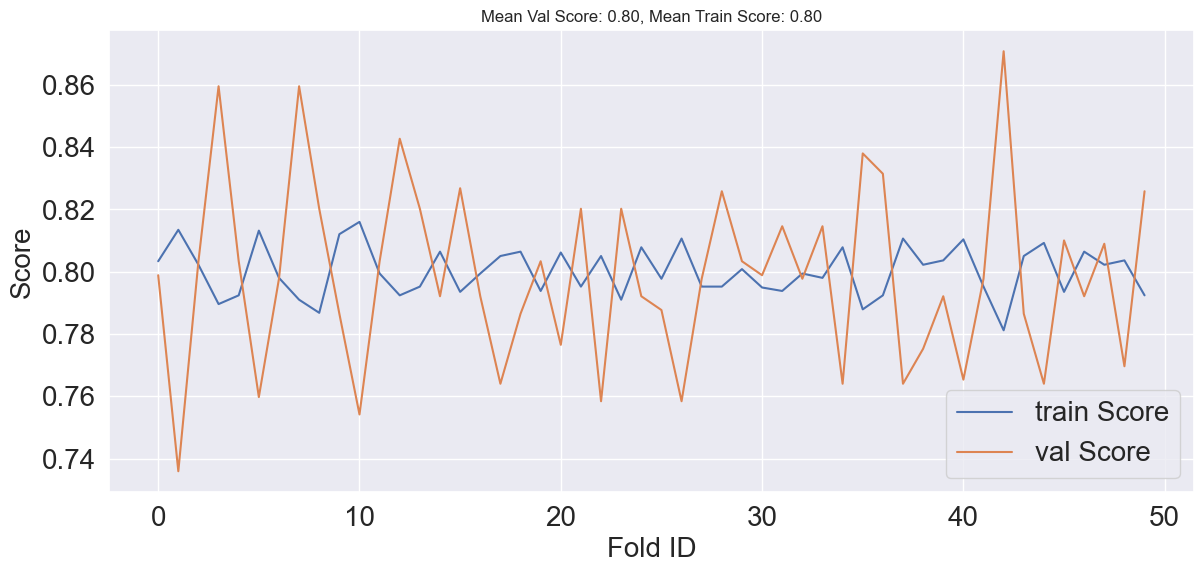

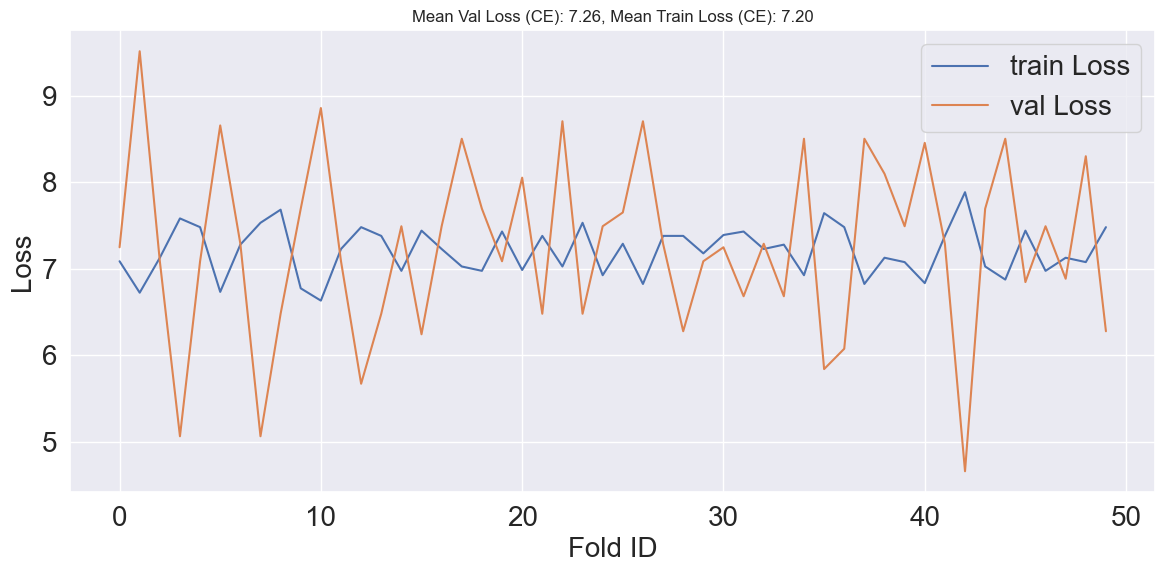

                 Metric Value
      Mean CV Val Score  0.80
  Mean CV Val Loss (CE)  7.26
    Mean CV Train Score  0.80
Mean CV Train Loss (CE)  7.20


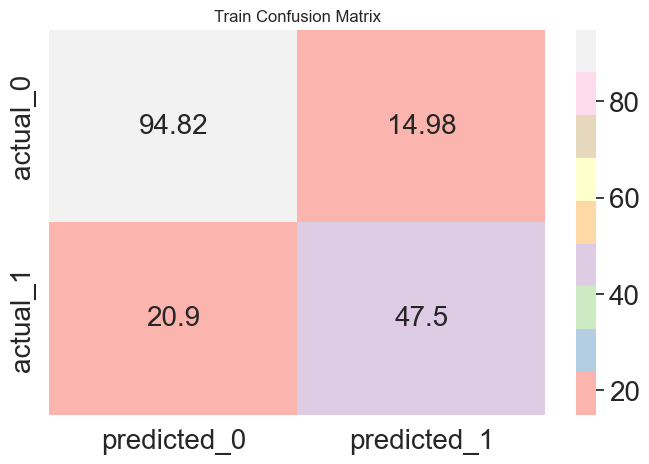

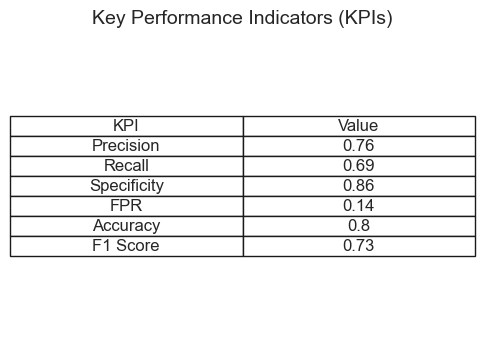

In [92]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X_selected_features, t, lda_model, k=num_of_fold, p=None, show_score_loss_graphs=True)

-  We can see that the best model is KNN, so we will use it to predict the test data

**Conclusion**<br>
The training and validation sets in the Titanic dataset are similar in how their data is spread out, the missing information, and the changes made to the data,

### Save the best model

In [ ]:
best_model = gs_neigh_model

## Tests Model

- Keep only the feature selection list

In [ ]:
test_data_selected_features = test_data[best_features]

print("test_data_selected_features: ", test_data_selected_features.shape)
test_data_selected_features.info()

- Run the model on test data

In [ ]:
predictions = best_model.predict(test_data_selected_features).astype(int)

- Create sumbission file for the test data

In [ ]:
submission_df = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})
submission_df.to_csv('submission.csv', index=False)



time = pd.Timestamp.now()
formatted_time = time.strftime('%H:%M:%S')
print(f"Your submission was successfully saved at time {formatted_time}")


## *Summary*

This project tackles the Titanic survival prediction challenge from Kaggle. The goal is to predict passenger survival based on various features like age, sex, ticket class, etc.<br><br>
Key steps in the project:

1. *Data preprocessing*: Handling missing values, encoding categorical variables, and feature engineering (e.g., creating FamilySize and IsAlone features).

2. *Exploratory Data Analysis (EDA)*: Visualizing relationships between features and survival rates.

3. *Feature selection:* Using Recursive Feature Elimination with Cross-Validation (RFECV) to identify the most relevant predictors.

4. *Model comparison:* Testing various algorithms including SGD Classifier, k-Nearest Neighbors, Naive Bayes, and Linear Discriminant Analysis.

5. *Ensemble methods:* Implementing Bagging (with and without bootstrap) and Boosting (AdaBoost) to improve model performance.

6. *Hyperparameter tuning*: Employing Grid Search and Random Search to optimize model parameters.

7. *Cross-validation*: Using k-fold cross-validation to assess model performance more robustly.

8. *Final prediction*: Selecting the best-performing model (likely KNN based on the notebook) to make predictions on the test set.

9. *Submission*: Creating a CSV file with predictions for submission to the Kaggle competition.

Throughout the process, various evaluation metrics and visualizations were used to guide decision-making and improve model performance.


## References:
Encyclopedia of the Titanic and its passengers:<br>
https://www.encyclopedia-titanica.org/

YouTube:<br>
To explain the structure of the ship, and the impact of the iceberg.